In [1]:
import os; os.chdir('..')
import sys; sys.path.extend(['.'])

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import dnnlib
from hydra.experimental import compose, initialize
from omegaconf import OmegaConf, DictConfig

initialize(config_path="../configs", job_name="test_app")
hydra_cfg = compose(config_name="config.yml")
device = 'cuda'
g_fmaps = 0.5

G_kwargs = dnnlib.EasyDict(
    class_name='training.networks.Generator',
    z_dim=512,
    w_dim=512,
    mapping_kwargs=dnnlib.EasyDict(),
    synthesis_kwargs=dnnlib.EasyDict()
)
G_kwargs.synthesis_kwargs.channel_base = int(g_fmaps * 32768)
G_kwargs.synthesis_kwargs.channel_max = 512
G_kwargs.synthesis_kwargs.use_noise = False
G_kwargs.mapping_kwargs.num_layers = 2
G_kwargs.synthesis_kwargs.num_fp16_res = 4 # enable mixed-precision training
G_kwargs.synthesis_kwargs.conv_clamp = 256 # clamp activations to avoid float16 overflow
G_kwargs.synthesis_cfg = OmegaConf.to_container(hydra_cfg.synthesis)
common_kwargs = dict(c_dim=0, img_resolution=256, img_channels=3)
G = dnnlib.util.construct_class_by_name(**G_kwargs, **common_kwargs).train().requires_grad_(False).to(device) # subclass of torch.nn.Module
G.synthesis.progressive_growing_update(25000)

In [2]:
import torch
import torchvision.transforms.functional as TVF

batch_size = 1
z = torch.randn(batch_size, G.z_dim).to(device)
z_before = torch.randn_like(z)
z_after = torch.randn_like(z)

c = None
modes_idx_kwargs = dict(modes_idx=torch.randint(0, 8, size=(batch_size,), device=z.device))
ws = G.mapping(z, c, **modes_idx_kwargs)
ws_before = G.mapping(z_before, c, **modes_idx_kwargs)
ws_after = G.mapping(z_after, c, **modes_idx_kwargs)
ws_context = torch.stack([ws_before, ws_after], dim=1)
# ws_context = torch.stack([G.mapping(z_before, c), G.mapping(z_after, c)], dim=1)

left_borders_idx = torch.zeros(batch_size, device=z.device).long() 
img_normal = G.synthesis(ws, ws_context=ws_context, left_borders_idx=left_borders_idx, noise='const')[0]

left_borders_idx = torch.zeros(batch_size, device=z.device).long() + 1
img_shifted = G.synthesis(ws, ws_context=ws_context, left_borders_idx=left_borders_idx, noise='const')[0]

Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


In [3]:
patch_size = 256//hydra_cfg.synthesis.patchwise.grid_size
torch.allclose(img_normal[:, :, patch_size:], img_shifted[:, :, :-patch_size], atol=1e-3)

True

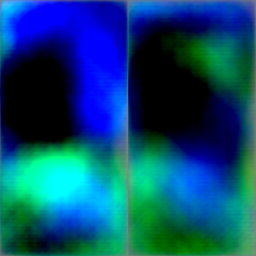

In [4]:
TVF.to_pil_image(img_normal.clamp(-1, 1) * 0.5 + 0.5)

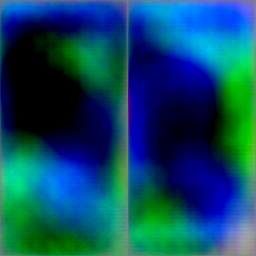

In [5]:
TVF.to_pil_image(img_shifted.clamp(-1, 1) * 0.5 + 0.5)